# Imports

In [13]:
import os
import networkx as nx
import numpy as np
import time
import torch
import torch.optim as optim
import torch.nn.functional as F
import random
import pandas as pd
import matplotlib.pyplot as plt


# Greedy Method

In [2]:
def largest_first_coloring(G, k):
    # Order nodes by degrees in descending order
    nodes_sorted_by_degree = sorted(G.nodes(), key=lambda node: -G.degree(node))
    
    # Dictionary to hold the color assigned to each node
    coloring = {}
    
    # Available colors set to track used colors
    available_colors = set(range(k))
    
    for node in nodes_sorted_by_degree:
        # Find the first available color that is not used by its neighbors
        used_colors = {coloring.get(neighbor) for neighbor in G.neighbors(node) if neighbor in coloring}
        node_color = next((color for color in available_colors if color not in used_colors), None)
        
        # If no available color is found within the limit, break or skip the node
        if node_color is None:
            coloring[node] = k+1
            continue
        
        # Assign the color to the node
        coloring[node] = node_color

    return coloring

# HEO 

In [3]:
class heo():
        
    def __init__(self, dim, k, energy_func, opt_config, device='cpu'):
        self.dim = dim
        self.energy_func = energy_func
        self.device = device
        self.opt_config = opt_config
        self.k = k

    def phi(self, mu, sigma):
        return torch.erf(mu / sigma / np.sqrt(2))
    
    def rho(self, x):
        return torch.tan(np.pi*x-0.5*np.pi)
    
    def initialize(self):
        self.theta = torch.ones(self.dim, self.k, device=self.device) * 0.5
        self.theta.requires_grad = True
        x = self.phi(self.theta - torch.rand(self.dim, self.k, device=self.device), 1)
        self.energy = self.energy_func(x)
    
    def update(self, t, T):
        sigma = (1 - t / T)
        x = self.phi(self.rho(self.theta) - self.rho(torch.rand(self.dim, self.k, device=self.device)), sigma)
        self.energy = self.energy_func(x)
        self.energy.backward()
        self.opt.step()
        self.opt.zero_grad()
        self.theta.data = torch.clamp(self.theta.data, 0, 1)

    def solver(self, T, save_enegry=False):
        self.initialize()
        if self.opt_config['type'] == 'sgd':
            self.opt=optim.SGD([self.theta], lr=self.opt_config['lr'], momentum=self.opt_config['momentum'])
        elif self.opt_config['type'] == 'adam':
            self.opt=optim.Adam([self.theta], lr=self.opt_config['lr'])
        if save_enegry:
            enegry_s = [self.energy.detach().cpu()]
        for t in range(T):
            self.update(t,T)
            if save_enegry:
                enegry_s.append(self.energy.detach().cpu())
        if save_enegry:
            return self.theta.detach().cpu(), enegry_s
        else:
            return self.theta.detach().cpu()
        
def energy_func(x):

    n, _ = x.shape

    max_positions = torch.softmax(x / 10 ,dim=1)
    max_overlap = torch.matmul(max_positions, max_positions.T)  # [n, n]
    adjacency_penalties = max_overlap * couplings
    penalty = adjacency_penalties.fill_diagonal_(0).sum()

    penalty = penalty / n

    return penalty

# Tabucol

In [4]:
def tabucol(G, k, max_iter=10000):
    # Initialize the color of each node with a random color
    colors = {node: random.randint(0, k-1) for node in G.nodes()}
    
    # Function to check if current coloring is valid
    def valid_coloring():
        for u, v in G.edges():
            if colors[u] == colors[v]:
                return False
        return True

    # Tabu list to keep track of moves that are forbidden
    tabu_list = {}
    tabu_tenure = len(G.nodes()) // 2

    # Best solution found so far
    best_solution = dict(colors)
    
    for _ in range(max_iter):
        if valid_coloring():
            return colors  # Return the coloring if it is valid
        
        # Choose a conflicted node
        conflicted_nodes = [u for u in G.nodes() if any(colors[u] == colors[v] for v in G.neighbors(u))]
        node = random.choice(conflicted_nodes)
        
        # Choose a color that minimizes the conflict
        current_color = colors[node]
        conflicts = {color: sum(1 for neighbor in G.neighbors(node) if colors[neighbor] == color)
                     for color in range(k) if color != current_color}

        # Find the color with the least conflict
        new_color, _ = min(conflicts.items(), key=lambda x: x[1])

        # Check if move is tabu, unless it's better than the current best
        if (node, new_color) in tabu_list and _ < max_iter - tabu_tenure:
            continue

        # Update the color of the node
        colors[node] = new_color
        
        # Update tabu list
        tabu_list[(node, current_color)] = _ + tabu_tenure
        
        # Update the best solution if current is better
        if sum(1 for u, v in G.edges() if colors[u] == colors[v]) < sum(1 for u, v in G.edges() if best_solution[u] == best_solution[v]):
            best_solution = dict(colors)

    return best_solution

# Evaluation function

In [5]:
def eval(c, start_time, end_time, G, k):
    
    # Time for running experiment
    t  = end_time - start_time

    # Total Edges
    e = G.number_of_edges()
    e_v = 0

    # Edge violations
    for u, v in G.edges():
        if c[u] == c[v]:
            e_v += 1
        elif c[u] == k+1 | c[v] == k+1 :
            e_v += 1
        
    # Edge violation percent
    ve = 100*e_v/e
    k_ = len(set(c.values()))
    k_ratio = k_/k
    

    return ve, t, k_, e_v, e



# Experiment Configs

In [6]:
config = {'device':'cpu',
           'datapath': './',
           'type':'sgd',
           'lr':10,
           'momentum':0,
           'T':5000
           }

prob_list = os.listdir(config['datapath'])
instance_num = len(prob_list)

# Running experiments

In [7]:
ve_ = []
t_ = []
k_ = []
method = []
e_v_ = []
e_ = []
dim_ = []
ind_ = []
k_ratio_ = []

for inst_index in np.arange(instance_num):#(instance_num):
    load_dir = r'{}/{}'.format(config['datapath'], prob_list[inst_index])
    with open(load_dir) as f:
        lines = f.readlines()

    k = int([line for line in lines if line.startswith("c Leighton's proof : ")][0].split(": ")[1].split(" ")[0])
    u = [int(line.replace('e ', '').replace('\n', '').split(" ")[0]) for line in lines if line.startswith("e ")]
    v = [int(line.replace('e ', '').replace('\n', '').split(" ")[1]) for line in lines if line.startswith("e ")]

    nodes = list(set(u + v))
    node_to_index = {node: index for index, node in enumerate(nodes)}
    size = len(nodes)
    a = [[0] * size for _ in range(size)]

    # Populate the adjacency matrix based on u, v pairs
    for node1, node2 in zip(u, v):
        index1 = node_to_index[node1]
        index2 = node_to_index[node2]
        a[index1][index2] = 1

    G = nx.from_numpy_matrix(np.array(a))
    dim = size
    couplings = torch.tensor(a, dtype = float)

    # Running Greedy

    start_time = time.perf_counter()
    c = largest_first_coloring(G, k)
    end_time = time.perf_counter()
    ve, t, k_ratio, e_v, e = eval(c, start_time, end_time, G, k)

    ind_.append(inst_index)
    ve_.append(ve)
    t_.append(t)
    k_.append(k)
    method.append('Greedy')
    e_v_.append(e_v)
    e_.append(e)
    dim_.append(len(list(set(u + v))))
    k_ratio_.append(k_ratio)

    # Running HEO

    start_time = time.perf_counter()       
    solver =  heo(dim=dim, k = k, energy_func=energy_func, opt_config=config)
    p = solver.solver(T=config['T'])
    p_ = torch.argmax(p, axis = 1)
    c = {index: element.item() for index, element in enumerate(p_)}
    end_time = time.perf_counter()
    ve, t, k_ratio, e_v, e = eval(c, start_time, end_time, G, k)

    ind_.append(inst_index)
    ve_.append(ve)
    t_.append(t)
    k_.append(k)
    method.append('HEO')
    e_v_.append(e_v)
    e_.append(e)
    dim_.append(len(list(set(u + v))))
    k_ratio_.append(k_ratio)


    # Running Tabucol

    start_time = time.perf_counter()
    c = tabucol(G, k)
    end_time = time.perf_counter()
    ve, t, k_ratio, e_v, e = eval(c, start_time, end_time, G, k)

    ind_.append(inst_index)
    ve_.append(ve)
    t_.append(t)
    k_.append(k)
    method.append('Tabucol')
    e_v_.append(e_v)
    e_.append(e)
    dim_.append(len(list(set(u + v))))
    k_ratio_.append(k_ratio)


results = pd.DataFrame({'Instance No.' : ind_, 
                        'Nodes' : dim_,
                        'Edges' : e_,
                        'Chromatic Number' : k_,
                        'Method' : method,
                        'Chromatic Number Achieved' : k_ratio_,
                        'Edges violating coloring' : e_v_,
                        'Percent of edges violating coloring' : ve_})

results.to_csv('results.csv')


In [8]:
results

,Instance No.,Nodes,Edges,Chromatic Number,Method,Chromatic Number Achieved,Edges violating coloring,Percent of edges violating coloring
0,0,450,16750,15,Greedy,16,1904,11.367164
1,0,450,16750,15,HEO,15,1132,6.758209
2,0,450,16750,15,Tabucol,15,474,2.829851
3,1,450,9757,5,Greedy,6,3047,31.228861
4,1,450,9757,5,HEO,5,1604,16.439479
5,1,450,9757,5,Tabucol,5,1366,14.000205
6,2,450,8260,25,Greedy,26,0,0.000000
7,2,450,8260,25,HEO,25,355,4.297821
8,2,450,8260,25,Tabucol,25,12,0.145278
9,3,450,17343,25,Greedy,26,472,2.721559


# Plotting Results

In [14]:
results = pd.read_csv('results.csv')

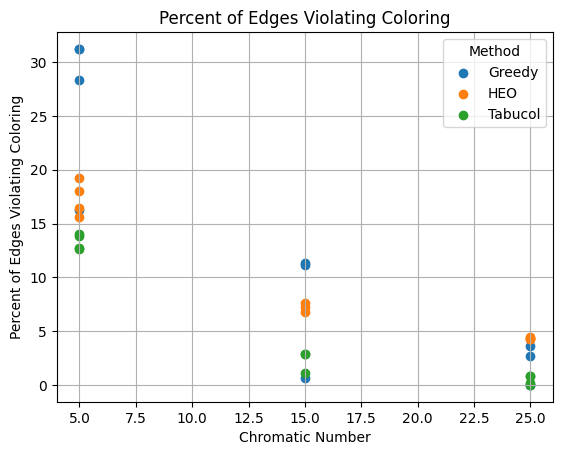

In [25]:

# Plotting
fig, ax = plt.subplots()

for method in results['Method'].unique():
    subset = results[results['Method'] == method]
    subset = subset.sort_values(by = 'Chromatic Number')
    ax.scatter(x=subset['Chromatic Number'], y=subset['Percent of edges violating coloring'], label=method)

plt.title('Percent of Edges Violating Coloring')
plt.xlabel('Chromatic Number')
plt.ylabel('Percent of Edges Violating Coloring')
plt.legend(title='Method')
plt.grid(True)
plt.savefig('k_ve.png', format='png', dpi=300) 
plt.show()



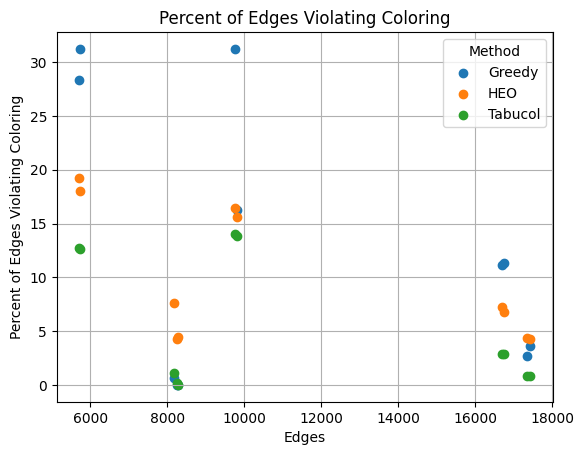

In [26]:
# Plotting
fig, ax = plt.subplots()

for method in results['Method'].unique():
    subset = results[results['Method'] == method]
    subset = subset.sort_values(by = 'Edges')
    ax.scatter(x=subset['Edges'], y=subset['Percent of edges violating coloring'], label=method)

plt.title('Percent of Edges Violating Coloring')
plt.xlabel('Edges')
plt.ylabel('Percent of Edges Violating Coloring')
plt.legend(title='Method')
plt.grid(True)
plt.savefig('edge_ve.png', format='png', dpi=300) 
plt.show()



<Figure size 1000x600 with 0 Axes>

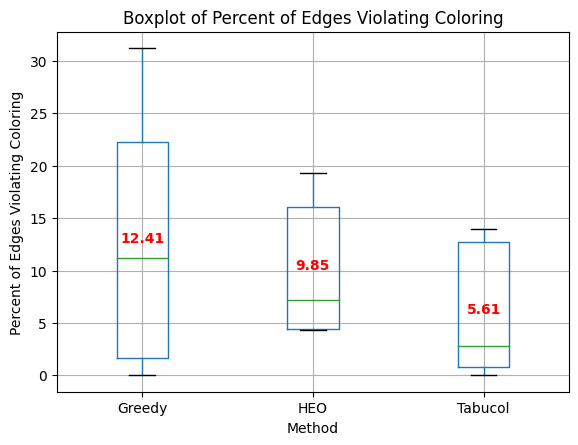

In [11]:
# Creating the boxplot
plt.figure(figsize=(10, 6))  # Set the figure size (optional)
ax = results.boxplot(by='Method', column='Percent of edges violating coloring', grid=True, showfliers=True)

means = results.groupby('Method')['Percent of edges violating coloring'].mean()

for i, mean in enumerate(means):
    ax.text(i + 1, mean, f'{mean:.2f}', color='red', ha='center', va='bottom', fontweight='bold')


plt.title('Boxplot of Percent of Edges Violating Coloring')
plt.suptitle('')  # Suppress the default title to clean up the plot title
plt.xlabel('Method')
plt.ylabel('Percent of Edges Violating Coloring')
plt.savefig('boxplot_ve.png', format='png', dpi=300) 
plt.show()